#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
#импортируем необходимые библиотеки
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import timeit


import statsmodels.api as sm


#отключим заранее предупреждения
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# загружаем исходные данные
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

#сортируем и ресемплируем данные
data.sort_index(inplace=True)
daily_data = data.resample('1D').sum()
data = data.resample('1H').sum()

# выводим основную информацию о датасете
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [ ]:
data.tail(5)

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


## Анализ

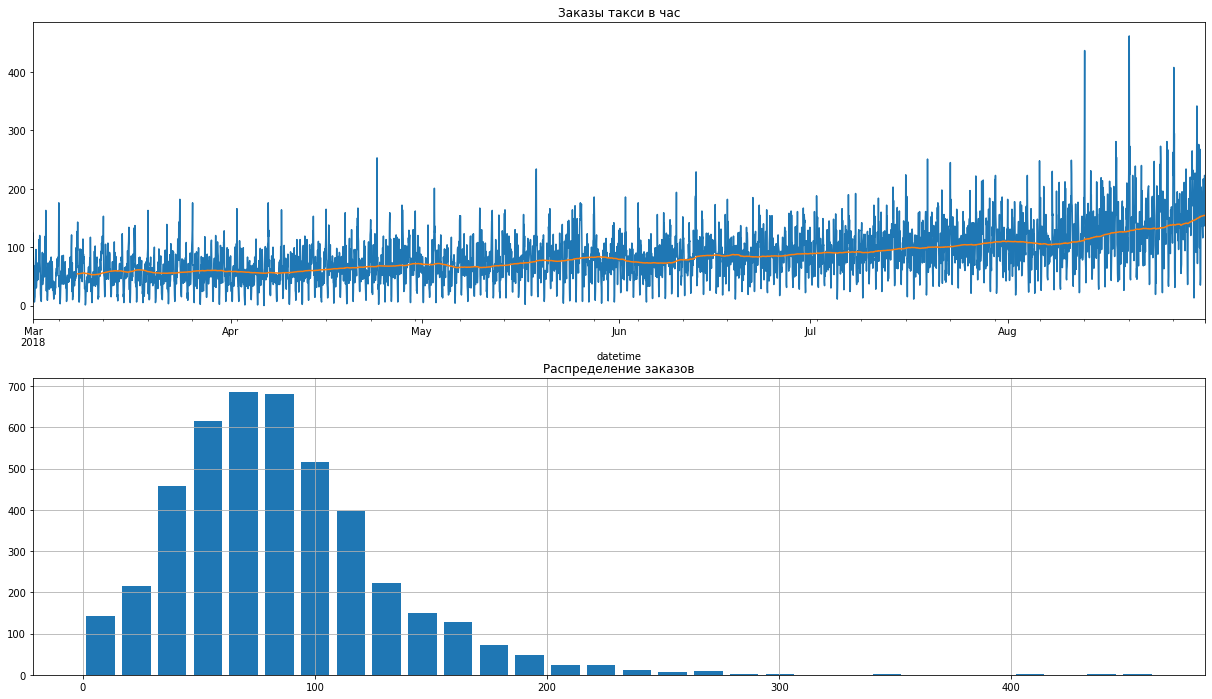

In [ ]:
# выведем график заказов такси в час за весь период
plt.figure(figsize = (21,12))
plt.subplot(211)
plt.title('Заказы такси в час')
data.num_orders.plot(ax = plt.gca())
data.num_orders.rolling(24*7).mean().plot(ax = plt.gca())

plt.subplot(212)
data.num_orders.hist(ax=plt.gca(), bins = 30, rwidth = 0.8)
plt.title('Распределение заказов')
plt.show()

***Промежуточный вывод***
* Первый график не самый информативный график. Однако, уже здесь мы видим, что имеется некий повышательный тренд. Воспользуемся seasonal_decompose, чтобы получше убедиться. 
* Гистограмма указывает на практически нормальное распределение, однако присутствует асиммтерия (правосторонняя скошенность). Это может обьясняться наличием тренда.



<div style="background: #aaccee ; padding: 5px; border: 1px solid blue; border-radius: 5px;">
<font color='blue'> 
<u>Промежуточный вывод 2:</u>
</font>
<font color='blue'><br>
    
* Все-таки смущает меня высокий уровень заказов к концу наблюдений (в августе), нужно разобраться
   

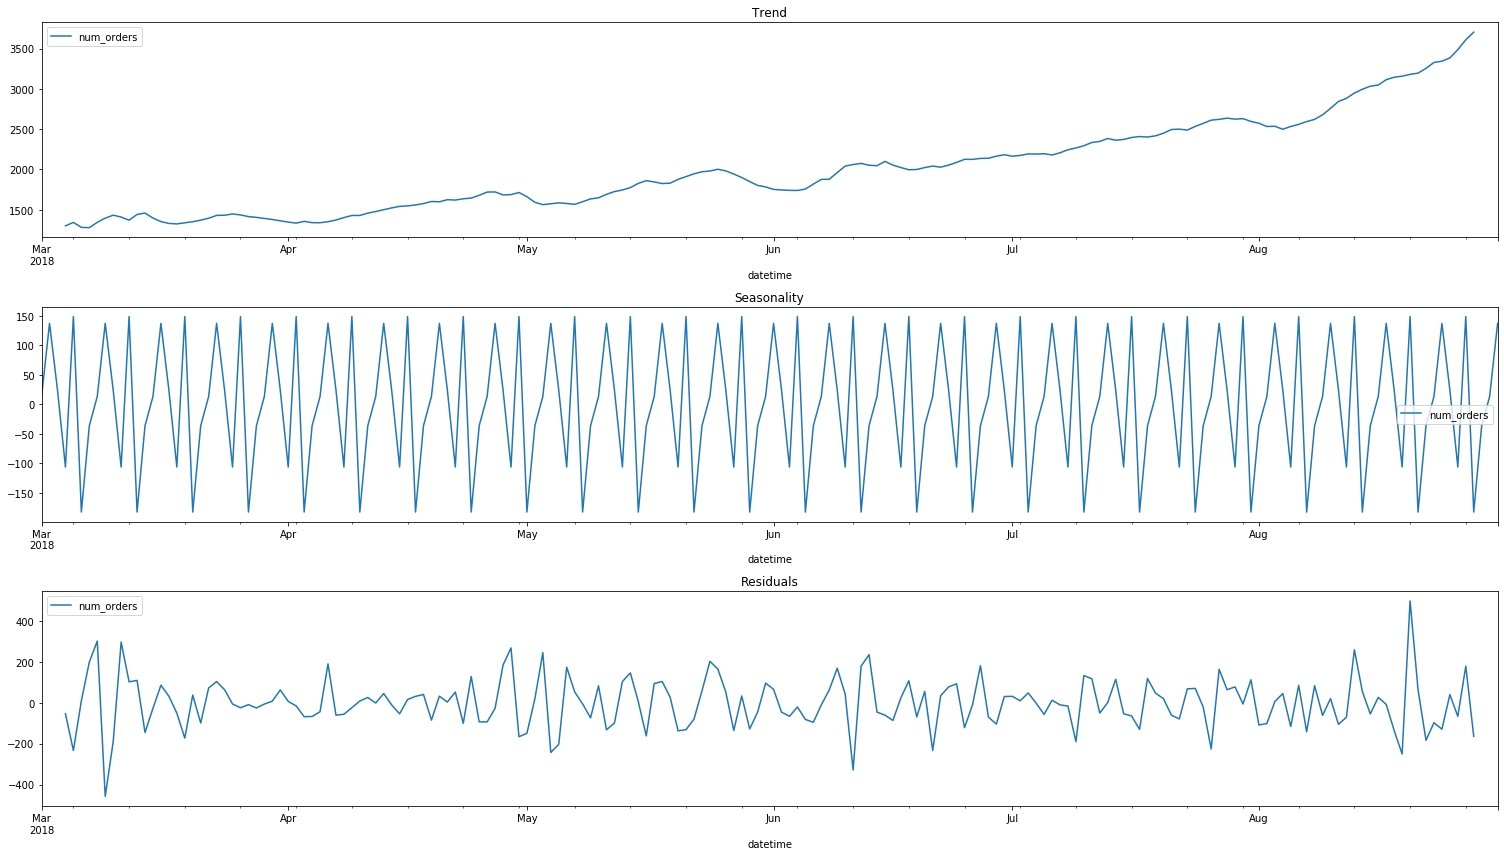

In [ ]:
# для начала разберемся с дневными данными, проверим есть ли какая то сезонность внутринедели.
decomposed = seasonal_decompose(daily_data)

plt.figure(figsize=(21, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal .plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid .plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

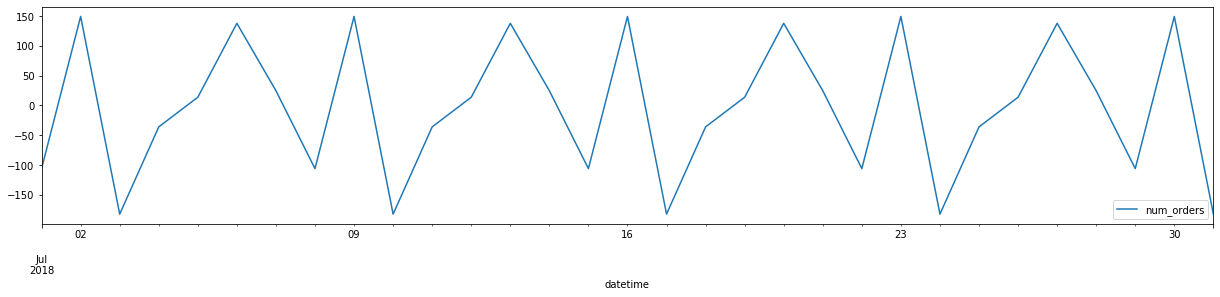

In [ ]:
plt.figure(figsize=(21, 4))
decomposed.seasonal['2018-07-01':'2018-07-31'].plot(ax=plt.gca())
plt.show()

<div style="background: #aaccee ; padding: 5px; border: 1px solid blue; border-radius: 5px;">
<font color='blue'> 
<u>Промежуточный вывод 2:</u>
</font>
<font color='blue'><br>
    
* Сезонность дневная присутствует и она ярковыраженная. Каждый вторник и воскресенье - спады, в то время как каждую пятницу и понедельник новый пик.

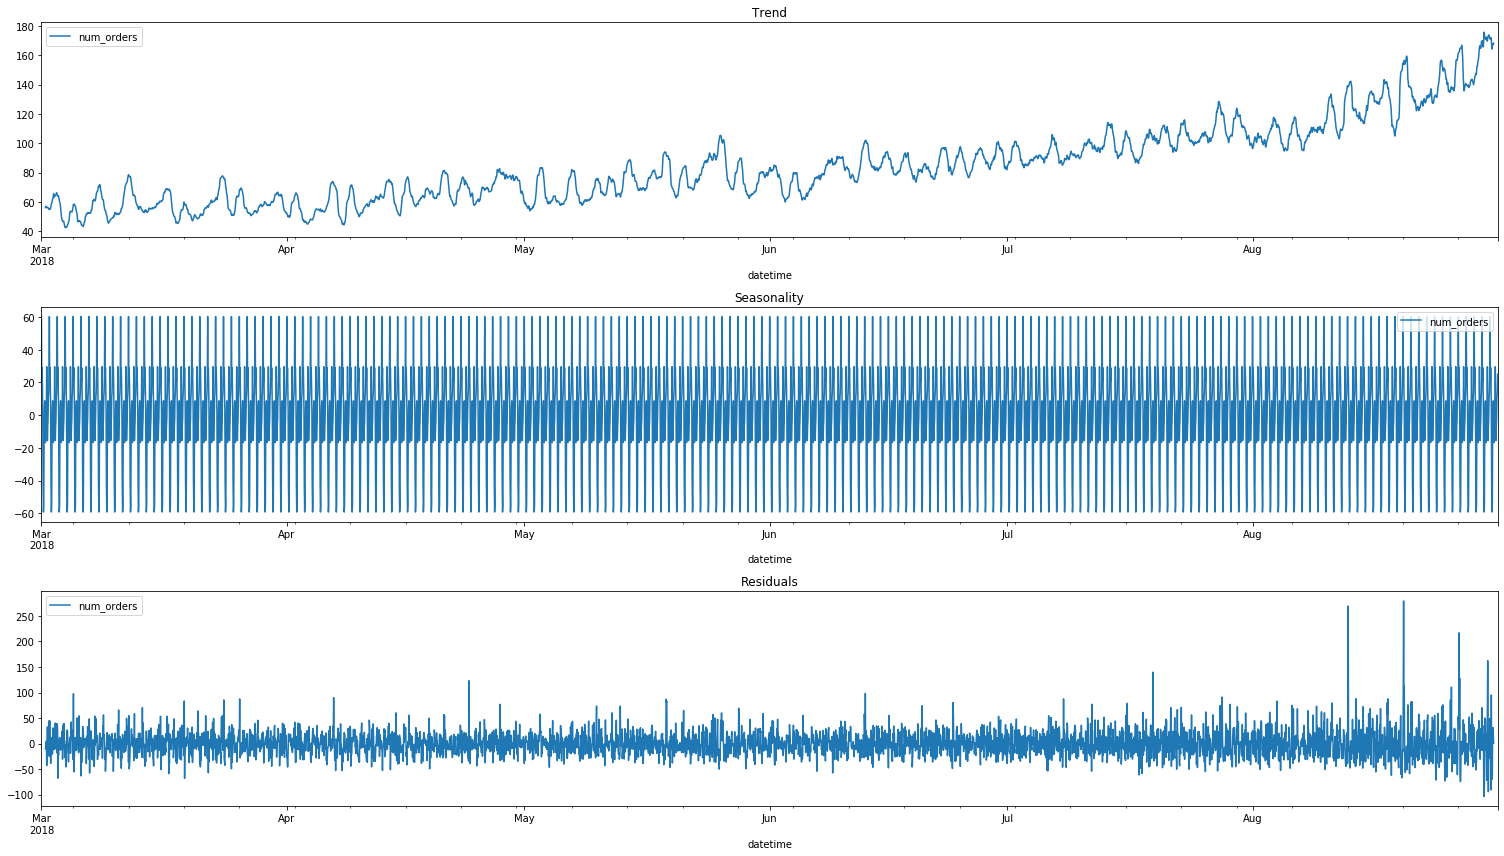

In [ ]:
# Теперь попробуем разобраться с внутридневной сезонностью
decomposed = seasonal_decompose(data)

fig = plt.figure(figsize=(21, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal .plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid .plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

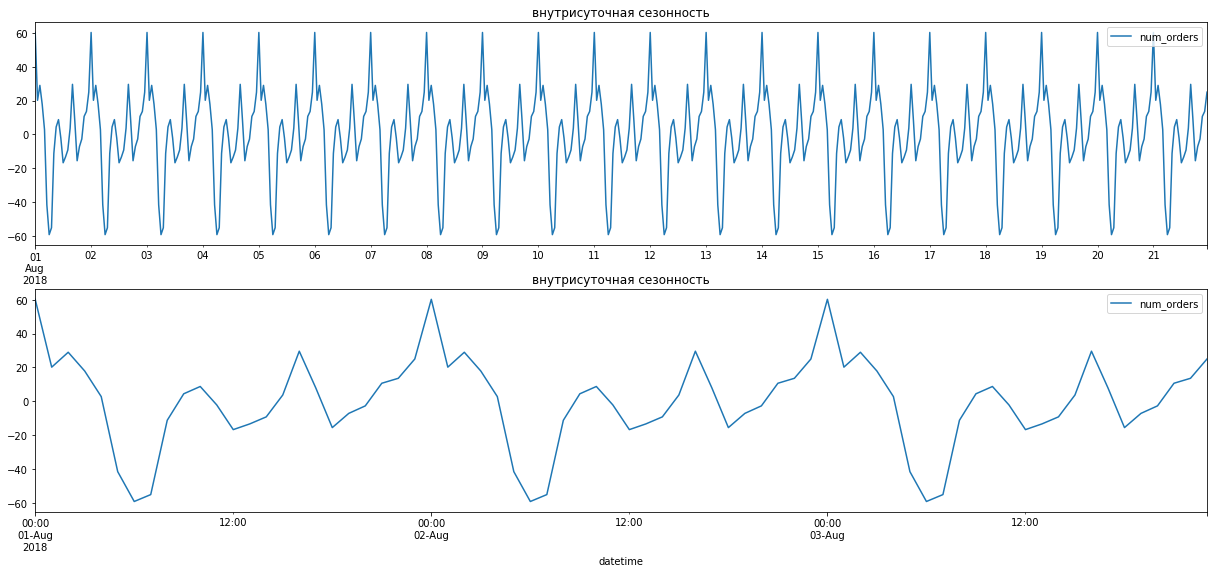

In [ ]:
fig = plt.figure(figsize = (21,9))
plt.subplot(211)
decomposed.seasonal['2018-08-01':'2018-08-21'].plot(ax = plt.gca())
plt.title('внутрисуточная сезонность')
plt.subplot(212)
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax = plt.gca())
plt.title('внутрисуточная сезонность')
plt.show()

<div style="background: #aaccee ; padding: 5px; border: 1px solid blue; border-radius: 5px;">
<font color='blue'> 
<u>Промежуточный вывод 2:</u>
</font>
<font color='blue'><br>
    
* Внутрисуточная сезонность тоже присутствует. Мы видим, что каждым утром в 6 утра наблюдается снижение спроса, ближе к 12 ночи спрос максимальный.

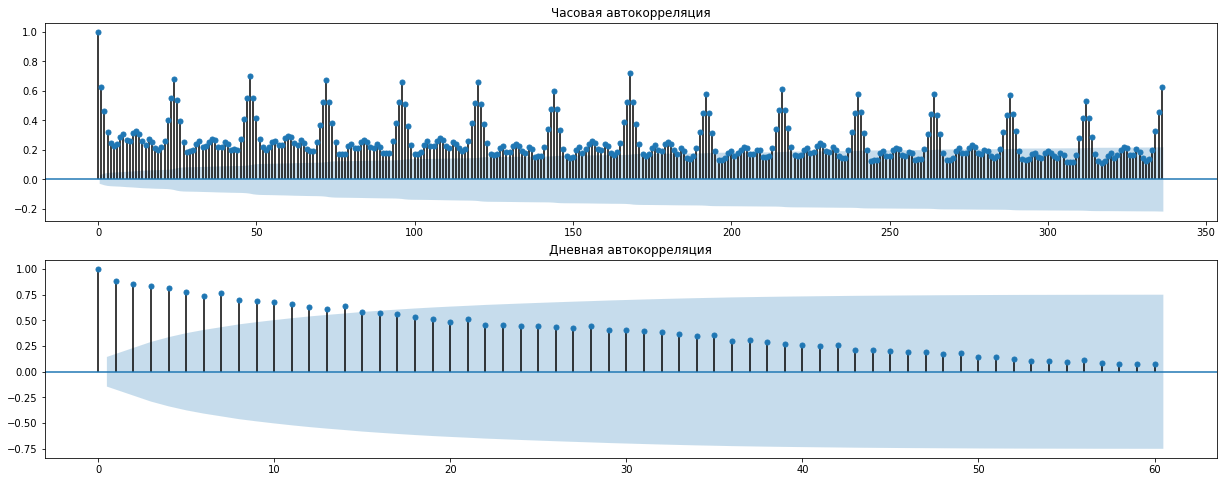

In [ ]:
fig = plt.figure(figsize=(21,8))
plt.subplot(211)
sm.graphics.tsa.plot_acf(data['num_orders'], lags=336, ax=plt.gca())
plt.title('Часовая автокорреляция')
plt.subplot(212)
sm.graphics.tsa.plot_acf(daily_data['num_orders'], lags=60, ax=plt.gca())
plt.title('Дневная автокорреляция')
plt.show()

***Промежуточный вывод***
    
* График часовой автокорреляции подтверждает наличие внутрисуточной сезонности (?). Мы наблюдаем интересную картину: пики корреляции каждые 24 лага (24 часа) и каждые 168 лага (неделя). 
* Однако, неожиданно, если мы посмотрим на график по дневным данным, то увидим, что да, каждый 7 лаг (неделя) есть пик корреляции, однако, каждую след неделю он уменьшается. (кстати, тоже самое можно сказать и про часовой график). Я думаю, это из-за наличия тренда.

In [ ]:
data[data['num_orders'] >= 350]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408


***Промежуточный вывод***
    
* А вот те самые выбросы, которые ломают всю (метрику). Если посмотреть на график остатков в конце блокнота, то можно увидеть, что именно эти выбросы не может предсказать модель.
* Удалять их точно будет ошибкой, так как в них есть структура (?)- они происходят каждый понедельник в 2 часа ночи...если честно, это больше похоже на то, что в августе в этот аэропорт прилетает новый рейс, пассажиры которого заказывают такси)))

Удаление этих выбросов больше будет похоже на подгонку метрики, как мне кажется.

## Обучение

In [ ]:
# создадим функцию для классификации времени суток т.к. есть временная зависимость 
def partofday_func(hour):
    if hour <6:
        return 'ночь'
    if hour >= 6 and hour < 10:
        return 'утро'
    if hour >= 10 and hour < 18:
        return 'день'
    if hour >=18:
        return 'вечер'

# создадим функцию для добавления фичей.
def make_features(data, maxlag, movingaverage, dayofweek = True, hourofday = True):
    # добавляем столбцы с отстающими значениями 
    for lag in maxlag:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    for ma in movingaverage:
        data['ma_{}'.format(ma)] = data['num_orders'].shift(1).rolling(ma).mean()   
    
    
    if dayofweek == True:
        data['dayofweek'] = data.index.dayofweek
    
    if hourofday == True:
        data['hourofday'] = data.index.hour


    return data

# была идея ввести данную категорию, однако, метрику это только ухудшило. 

In [ ]:
# применим ранее написанные функции, а также удалим пропуски
work_data = make_features(data,[1,24,168],[24, 24*7])
work_data.dropna(inplace = True, axis = 0)

# 
work_data['dayofweek'] = work_data['dayofweek'].astype('category')
work_data['hourofday'] = work_data['hourofday'].astype('category')

cat_features = ['dayofweek', 'hourofday']
work_data.head(5)

,num_orders,lag_1,lag_24,lag_168,ma_24,ma_168,dayofweek,hourofday
datetime,,,,,,,,
2018-03-08 00:00:00,143,94.0,100.0,124.0,60.041667,54.226190,3,0
2018-03-08 01:00:00,78,143.0,121.0,85.0,61.833333,54.339286,3,1
2018-03-08 02:00:00,65,78.0,24.0,71.0,60.041667,54.297619,3,2
2018-03-08 03:00:00,68,65.0,66.0,66.0,61.750000,54.261905,3,3
2018-03-08 04:00:00,60,68.0,73.0,43.0,61.833333,54.273810,3,4


In [ ]:
train, test = train_test_split(work_data, test_size = 0.1, shuffle = False)
print('Послденее время в train: ',train.index[-1])
print('Первое время в test: ',test.index[0])

Послденее время в train:  2018-08-14 06:00:00
Первое время в test:  2018-08-14 07:00:00


In [ ]:
# делим выборку на обучающую и тестовую (тестовая выборка - 10% от всего датасета)
train_target = train['num_orders']
train_features = train.drop('num_orders', axis = 1)

test_target = test['num_orders']
test_features = test.drop('num_orders', axis = 1)

# напишем функцию RSME для определения ошибки модели
def my_func(y_true, y_predicted):
    rmse = mean_squared_error(y_true,y_predicted)**(1/2)
    return rmse 

# чтобы было можно использовать пользовательскую функцию в GridSearchCV воспользуемся функцией make_scorer
my_scorer = make_scorer(my_func, greater_is_better=False)

In [ ]:
int_lgbm_model = LGBMRegressor()

param_grid = {
    'learning_rate': [0.05,0.1,0.15,0.2,0.25],
    'n_estimators': [600,800,1000],
    'max_depth' : [15,20,25]
}

grid_search_lgbm = GridSearchCV(estimator = int_lgbm_model,
                                param_grid = param_grid,
                                cv=TimeSeriesSplit(n_splits=8).split(train_features),
                                scoring = my_scorer,
                                verbose = 3)
grid_search_lgbm.fit(train_features, train_target)

Fitting 8 folds for each of 45 candidates, totalling 360 fits
[CV] learning_rate=0.05, max_depth=15, n_estimators=600 ..............
[CV]  learning_rate=0.05, max_depth=15, n_estimators=600, score=-22.514, total=   0.1s
[CV] learning_rate=0.05, max_depth=15, n_estimators=600 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=15, n_estimators=600, score=-24.759, total=   0.2s
[CV] learning_rate=0.05, max_depth=15, n_estimators=600 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=15, n_estimators=600, score=-22.404, total=   0.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=600 ..............
[CV]  learning_rate=0.05, max_depth=15, n_estimators=600, score=-22.861, total=   0.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=600 ..............
[CV]  learning_rate=0.05, max_depth=15, n_estimators=600, score=-23.791, total=   0.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=600 ..............
[CV]  learning_rate=0.05, max_depth=15, n_estimators=600, score=-23.265, total=   0.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=600 ..............
[CV]  learning_rate=0.05, max_depth=15, n_estimators=600, score=-27.018, total=   0.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=600 ..............
[CV]  learning_rate=0.05, max_depth=15, n_estimators=600, score=-31.931, total=   0.3s
[CV] learning_rate=0.05, max_depth=15, n_estimators=800 ..............
[CV]  learning_rate=0.05, max_depth=15, n_estimators

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  2.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000025B803DEB48>,
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,...
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25],
                         'max_depth': [15, 20, 25],
                         'n_estimators': 

In [ ]:
grid_search_lgbm.best_params_

{'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 600}

In [ ]:
#обучаем и замеряем
start = timeit.default_timer()
lgbm_model = LGBMRegressor(learning_rate = 0.05, max_depth = 20, n_estimators = 600)
lgbm_model.fit(train_features, train_target)
stop = timeit.default_timer()
time_fit_lgm = stop - start

# предсказываем и замеряем
start = timeit.default_timer()
predictions_lgbm = lgbm_model.predict(test_features)
stop = timeit.default_timer()
time_predict_lgm = stop - start
lgbm_rmse = my_func(test_target, predictions_lgbm)
print('RMSE: ', lgbm_rmse)

print('Время обучения {:.2f} сек и время предсказания {:.2f} сек'.format(time_fit_lgm, time_predict_lgm))

RMSE:  42.164279167693586
Время обучения 0.29 сек и время предсказания 0.01 сек


In [ ]:
train_features_dummies = pd.get_dummies(train_features, columns = cat_features, drop_first = True)
test_features_dummies = pd.get_dummies(test_features, columns = cat_features, drop_first = True)

In [ ]:
start = timeit.default_timer()
linear_model = LinearRegression()
linear_model.fit(train_features_dummies,train_target)
stop = timeit.default_timer()
time_fit_linear = stop - start

start = timeit.default_timer()
predictions_linear = linear_model.predict(test_features_dummies)
stop = timeit.default_timer()
time_predict_linear = stop - start

linear_rmse = my_func(test_target, predictions_linear)
print('RMSE: ', linear_rmse)
print('Время обучения {:.2f} сек и время предсказания {:.2f} сек'.format(time_fit_linear, time_predict_linear))

RMSE:  34.62449969788087
Время обучения 0.02 сек и время предсказания 0.00 сек


In [ ]:
forest_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [100,150,250,300],
    'max_depth' : [15,20,25]
}

grid_search_linear = GridSearchCV(estimator = forest_model,
                                param_grid = param_grid,
                                cv=TimeSeriesSplit(n_splits=8).split(train_features),
                                scoring = my_scorer,
                                verbose = 3)
grid_search_linear.fit(train_features_dummies, train_target)


Fitting 8 folds for each of 12 candidates, totalling 96 fits
[CV] max_depth=15, n_estimators=100 ..................................
[CV] .... max_depth=15, n_estimators=100, score=-18.771, total=   0.2s
[CV] max_depth=15, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .... max_depth=15, n_estimators=100, score=-20.873, total=   0.3s
[CV] max_depth=15, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .... max_depth=15, n_estimators=100, score=-21.727, total=   0.4s
[CV] max_depth=15, n_estimators=100 ..................................
[CV] .... max_depth=15, n_estimators=100, score=-23.126, total=   0.6s
[CV] max_depth=15, n_estimators=100 ..................................
[CV] .... max_depth=15, n_estimators=100, score=-22.504, total=   0.7s
[CV] max_depth=15, n_estimators=100 ..................................
[CV] .... max_depth=15, n_estimators=100, score=-22.699, total=   0.8s
[CV] max_depth=15, n_estimators=100 ..................................
[CV] .... max_depth=15, n_estimators=100, score=-25.586, total=   0.9s
[CV] max_depth=15, n_estimators=100 ..................................
[CV] .... max_depth=15, n_estimators=100, score=-31.800, total=   1.1s
[CV] max_depth=15, n_estimators=150 ..................................
[CV] .... max_depth=15, n_estimators=150, score=-18.715, total=   0.2s
[CV] max_depth=15, n_estimators=150 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  2.2min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001657822FBC8>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='wa

In [ ]:
grid_search_linear.best_params_

{'max_depth': 15, 'n_estimators': 300}

In [ ]:
start = timeit.default_timer()
forest_model = RandomForestRegressor(n_estimators = 300, max_depth = 15 )
forest_model.fit(train_features_dummies,train_target)
stop = timeit.default_timer()
time_fit_forest = stop - start

start = timeit.default_timer()
predictions_forest = forest_model.predict(test_features_dummies)
stop = timeit.default_timer()
time_predict_forest = stop - start

forest_rmse = my_func(test_target, predictions_forest)
print('RMSE: ', forest_rmse)
print('Время обучения {:.2f} сек и время предсказания {:.2f} сек'.format(time_fit_forest, time_predict_forest))

RMSE:  42.620324108626455
Время обучения 4.24 сек и время предсказания 0.03 сек


In [ ]:
# построим модель по среднему значению
predictions_mean = pd.Series(train_target.mean(), index = test_target.index)
rmse_mean = my_func(test_target, predictions_mean)
print('RMSE: ', rmse_mean)

RMSE:  84.45113423436631


In [ ]:
# построим модель по среднему значению
predictions_shift = test_target.shift(fill_value = train_target.iloc[-1])
rmse_shift = my_func(test_target, predictions_shift)
print('RMSE: ', rmse_shift)

RMSE:  58.819724582830204


## Анализ результатов

In [ ]:
results = pd.DataFrame({
    'model' : ['lgbm','linear','forest','mean','shift'],
    'fit_time' : [time_fit_lgm,time_fit_linear,time_fit_forest, 0,0],
    'predict_time' : [time_predict_lgm,time_predict_linear,time_predict_forest, 0,0],
    'rmse' : [lgbm_rmse,linear_rmse,forest_rmse,rmse_mean,rmse_shift]
    
})
results.sort_values(by ='rmse')

,model,fit_time,predict_time,rmse
1,linear,0.022269,0.000958,34.624500
0,lgbm,0.286352,0.010311,42.164279
2,forest,4.241455,0.025581,42.620324
4,shift,0.000000,0.000000,58.819725
3,mean,0.000000,0.000000,84.451134


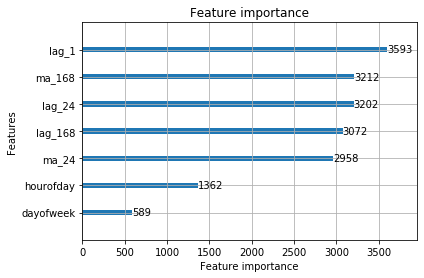

In [ ]:
plot_importance(lgbm_model)

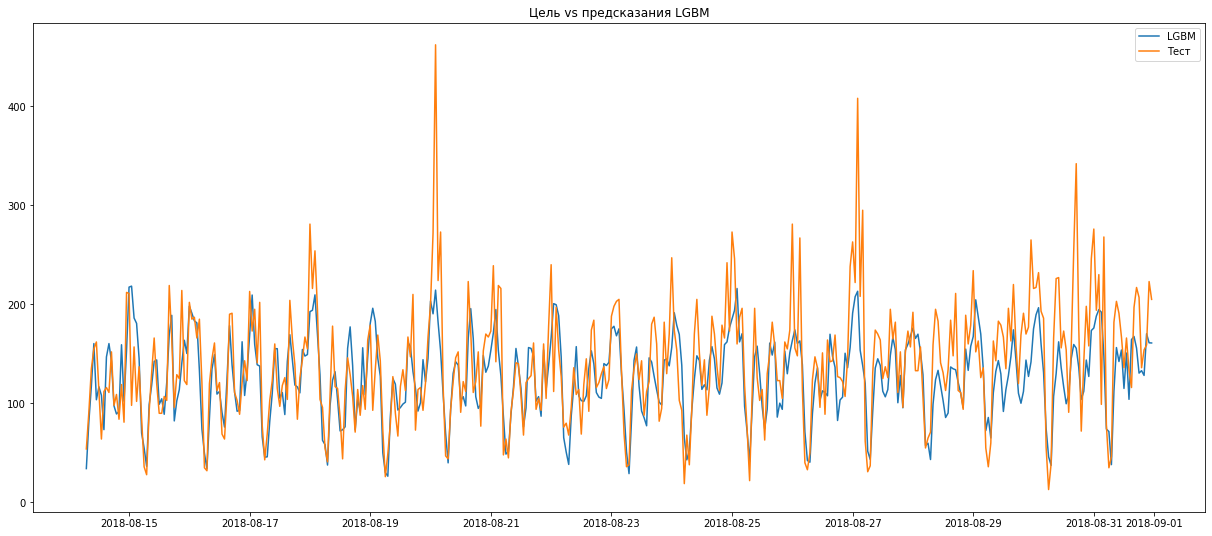

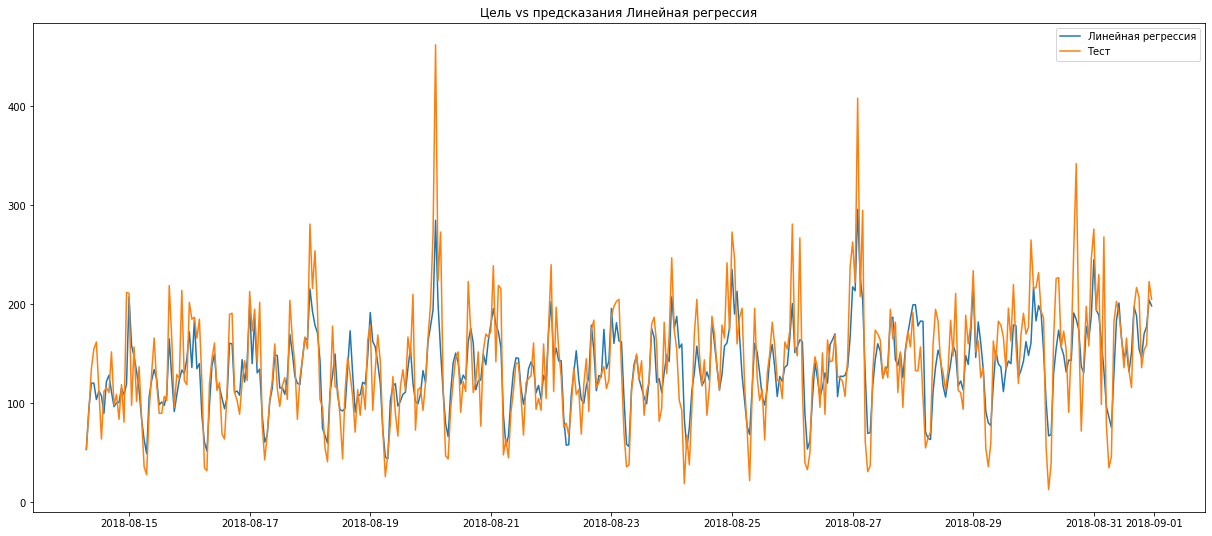

In [ ]:
predictions_lgbm = pd.Series(predictions_lgbm, index = test_target.index)
predictions_linear = pd.Series(predictions_linear, index = test_target.index)

fig = plt.figure(figsize = (21,9))
plt.title('Цель vs предсказания LGBM')
plt.plot(predictions_lgbm, label = 'LGBM')
plt.plot(test_target, label = 'Тест')
plt.legend()
plt.show()

fig = plt.figure(figsize = (21,9))
plt.title('Цель vs предсказания Линейная регрессия')
plt.plot(predictions_linear, label = 'Линейная регрессия')
plt.plot(test_target, label = 'Тест')
plt.legend()
plt.show()

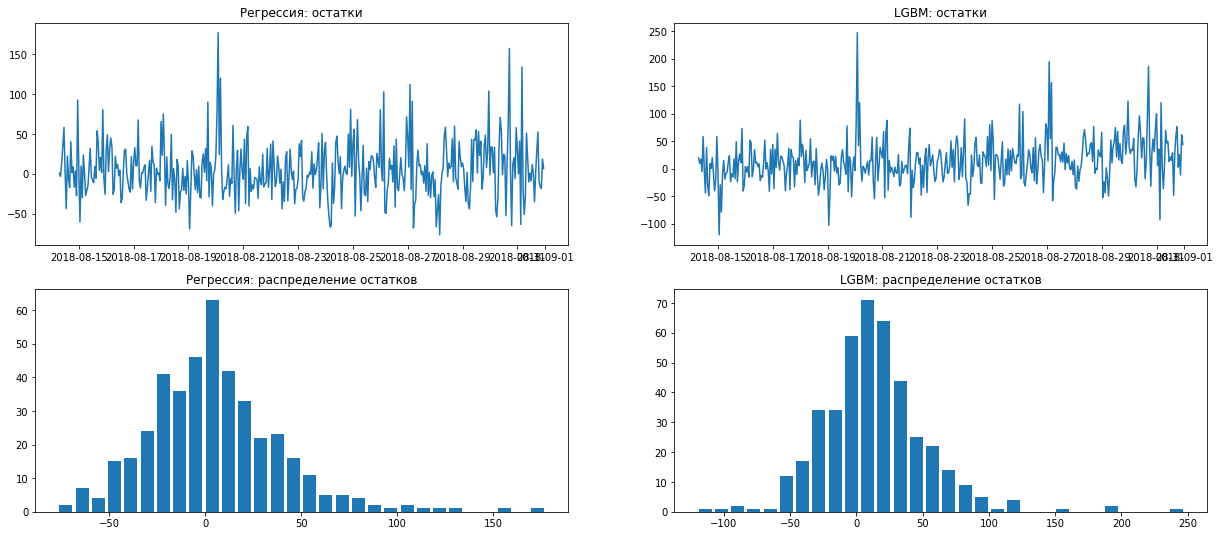

Среднее значение ошибки линейной регрессии составляет: 4.77
Cреднее значение ошибки LGBM модели составляет: 13.49


In [ ]:
noise_linear = test_target - predictions_linear
noise_lgbm = test_target - predictions_lgbm


fig = plt.figure(figsize = (21,9))

plt.subplot(221)
plt.plot(noise_linear)
plt.title('Регрессия: остатки')

plt.subplot(222)
plt.plot(noise_lgbm)
plt.title('LGBM: остатки')

plt.subplot(223)
plt.hist(noise_linear, bins = 30, rwidth = 0.8 )
plt.title('Регрессия: распределение остатков')

plt.subplot(224)
plt.hist(noise_lgbm, bins = 30, rwidth = 0.8 )
plt.title('LGBM: распределение остатков')

plt.show()
print('Среднее значение ошибки линейной регрессии составляет: {:.2f}'.format(noise_linear.mean()))
print('Cреднее значение ошибки LGBM модели составляет: {:.2f}'.format(noise_lgbm.mean()))

**Итоги:**

* Была выявлена зависимость количества заказов от времени суток и дня недели. 
* Были построены 3 рабочих модели (LGBM, случайного леса и линейной регрессии). Также, для сравнения была создана модель, которая предсказывает среднем значением, и модель, которая предсказывает все предыдущим значением. 
* Все три рабочие модели выполняли минимальные требования в rmse менее 48. 
* Стоит отдельно отметить, что разница в rmse у lgbm и линейной регрессии не сильная. Вторая модель обучается и предсказывает быстрее.
* Анализируя графики остатков, сказать, что присутствует четкая структура нельзя. Распределние ошибок выглядит приемущественно нормально. Единственное, средняя ошибка не равняется нулю... что может указывать на то, что модель, наверно, еще можно улчшить (?)



